In [2]:
import pandas as pd
from prophet import Prophet

df = pd.read_csv("AirtrafficA4.csv")

# dropping airline as there is just one airline

df.drop("AIRLINE", axis = 1, inplace = True)

removed = False

df.head(10)

if not(removed):
  col_rm_commas = list(df.columns)

  col_rm_commas.remove("YEAR")
  col_rm_commas.remove("MONTH")

  for attr in col_rm_commas:
    df[attr] = df[attr].str.replace(',', '').astype(float)
    # df[attr] = df[attr].bfill()
    df[attr] = df[attr].ffill()

  df_input = df.drop("PASSENGERS CARRIED", axis = 1)
  target = df["PASSENGERS CARRIED"]
  df.head()
  removed = True




df["MONTH"] = df["MONTH"].str.strip(" ")
month_mapping = {
    'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
    'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12
}

# Map the month names to numbers
df['MONTH'] = df['MONTH'].replace({'JUNE': 'JUN', 'JULY': 'JUL'})
df['month_num'] = df['MONTH'].map(month_mapping)

# Sort by 'year' and 'month_num'
df = df.sort_values(['YEAR', 'month_num']).reset_index(drop=True)

# Add the 'time' column starting from 0
df['time'] = range(len(df))

# Drop the helper 'month_num' column if no longer needed
df = df.drop(columns='month_num')

df['Date'] = pd.to_datetime(df['YEAR'].astype(str) + ' ' + df['MONTH'], format='%Y %b')
df.set_index('Date', inplace=True)





20:57:43 - cmdstanpy - INFO - Chain [1] start processing
20:57:43 - cmdstanpy - INFO - Chain [1] done processing


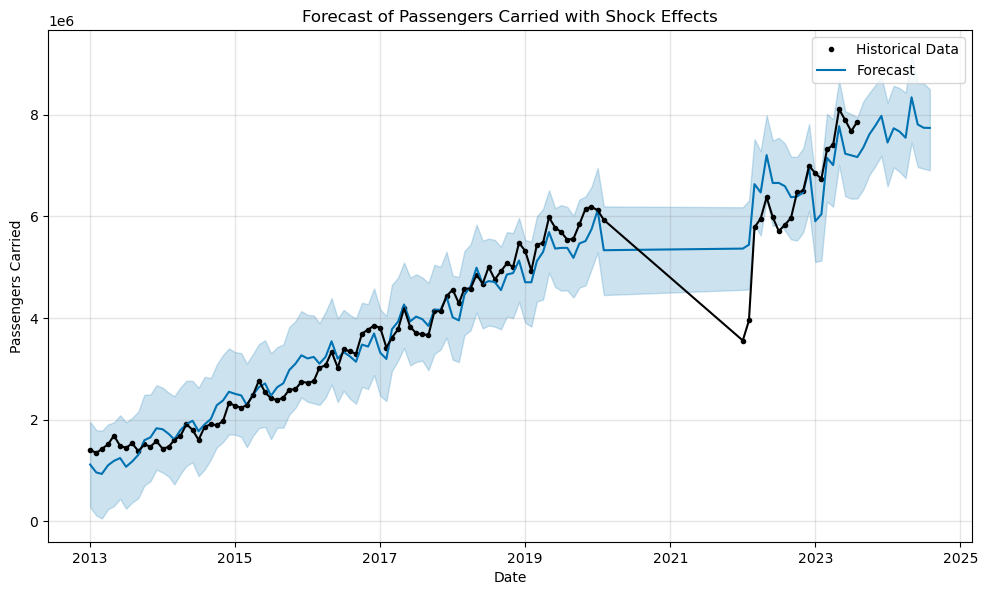

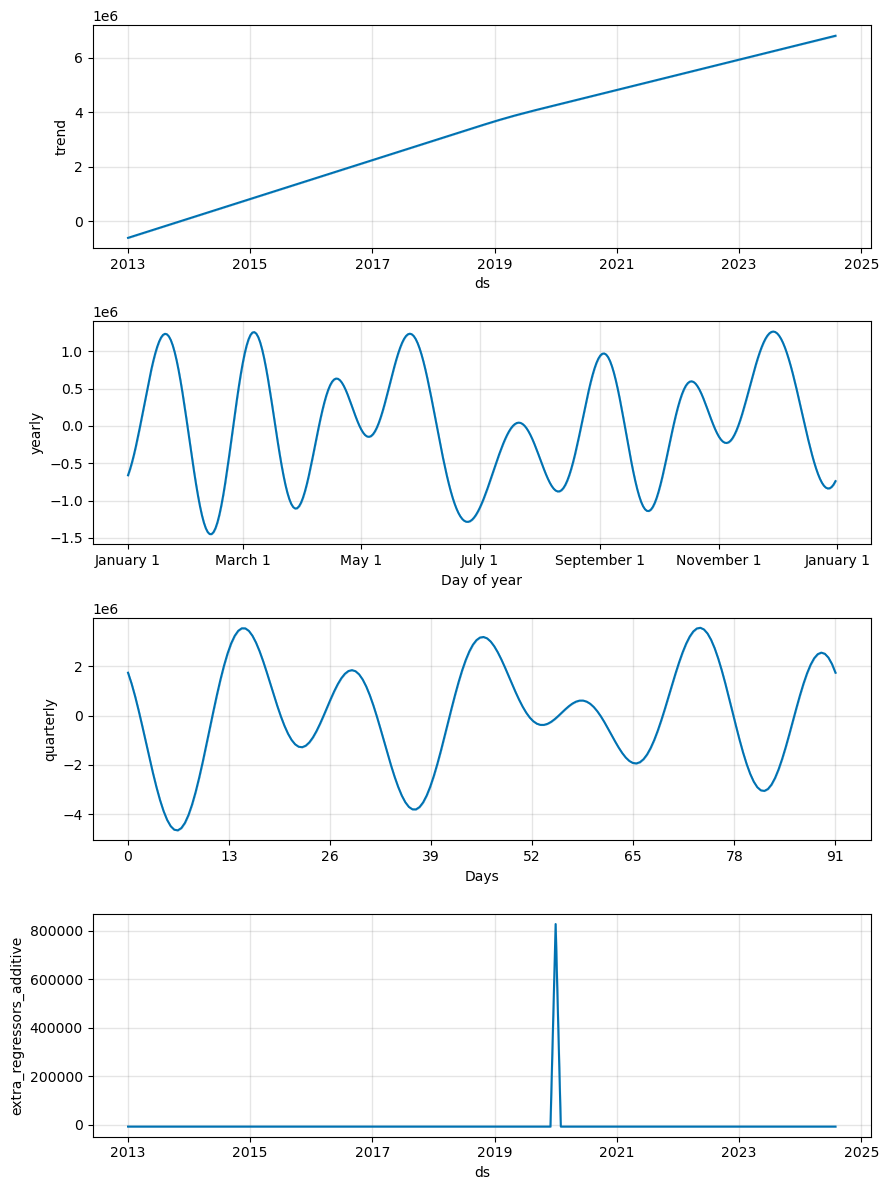

            ds          yhat    yhat_lower    yhat_upper
105 2023-08-01  7.168026e+06  6.353353e+06  7.950984e+06
106 2023-08-31  7.355408e+06  6.528193e+06  8.262443e+06
107 2023-09-30  7.611725e+06  6.810837e+06  8.428552e+06
108 2023-10-31  7.789258e+06  6.991621e+06  8.586145e+06
109 2023-11-30  7.979289e+06  7.192150e+06  8.753540e+06
110 2023-12-31  7.453743e+06  6.590292e+06  8.239689e+06
111 2024-01-31  7.734210e+06  6.965075e+06  8.570280e+06
112 2024-02-29  7.671586e+06  6.877354e+06  8.526315e+06
113 2024-03-31  7.548775e+06  6.754328e+06  8.434391e+06
114 2024-04-30  8.344567e+06  7.456730e+06  9.207879e+06
115 2024-05-31  7.809413e+06  6.970785e+06  8.622270e+06
116 2024-06-30  7.744163e+06  6.938132e+06  8.622760e+06
117 2024-07-31  7.741231e+06  6.908876e+06  8.499106e+06


In [34]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data for Prophet, excluding COVID-19 period
covid_start = '2020-03-01'
covid_end = '2021-12-31'
prophet_data = df[['PASSENGERS CARRIED']].rename(columns={'PASSENGERS CARRIED': 'y'}).reset_index().rename(columns={'Date': 'ds'})

prophet_data = prophet_data[(prophet_data['ds'] < covid_start) | (prophet_data['ds'] > covid_end)]

# Define shocks
# Create a DataFrame to represent shocks
shocks = pd.DataFrame({
    'ds': pd.to_datetime(['2020-01-01', '2020-05-01']),  # Dates of shocks
    'shock_effect': [2000, -3000]  # Hypothetical effects (adjust as needed)
})

# Merge shocks with the main dataset, filling in with zeros where there are no shocks
prophet_data = prophet_data.merge(shocks, on='ds', how='left').fillna(0)
prophet_data['shock_effect'] = prophet_data['shock_effect'].astype(float)

# Initialize Prophet with custom parameters
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    interval_width=0.95
)

# Add the shock regressor
model.add_regressor('shock_effect')

# Add quarterly seasonality with moderate fourier_order
model.add_seasonality(name='quarterly', period=91.25, fourier_order=6)

# Fit the model
model.fit(prophet_data)

# Make a future dataframe and forecast
future_dates = model.make_future_dataframe(periods=12, freq='M')
future_dates = future_dates.merge(shocks, on='ds', how='left').fillna(0)  # Include shocks in future
future_dates['shock_effect'] = future_dates['shock_effect'].astype(float)
forecast = model.predict(future_dates)

# Filter forecast for the last 12 months
last_12_months_forecast = forecast[forecast['ds'] >= forecast['ds'].max() - pd.DateOffset(months=12)]

# Plot the forecast with historical data
fig = model.plot(forecast)
plt.plot(prophet_data['ds'], prophet_data['y'], label="Historical Data", color='black')
plt.title("Forecast of Passengers Carried with Shock Effects")
plt.xlabel("Date")
plt.ylabel("Passengers Carried")
plt.legend(["Historical Data", "Forecast"])
plt.show()

# Plot seasonal components
fig2 = model.plot_components(forecast)
plt.show()

# Show the last 12 months of forecast data
print(last_12_months_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])


21:00:43 - cmdstanpy - INFO - Chain [1] start processing
21:00:43 - cmdstanpy - INFO - Chain [1] done processing


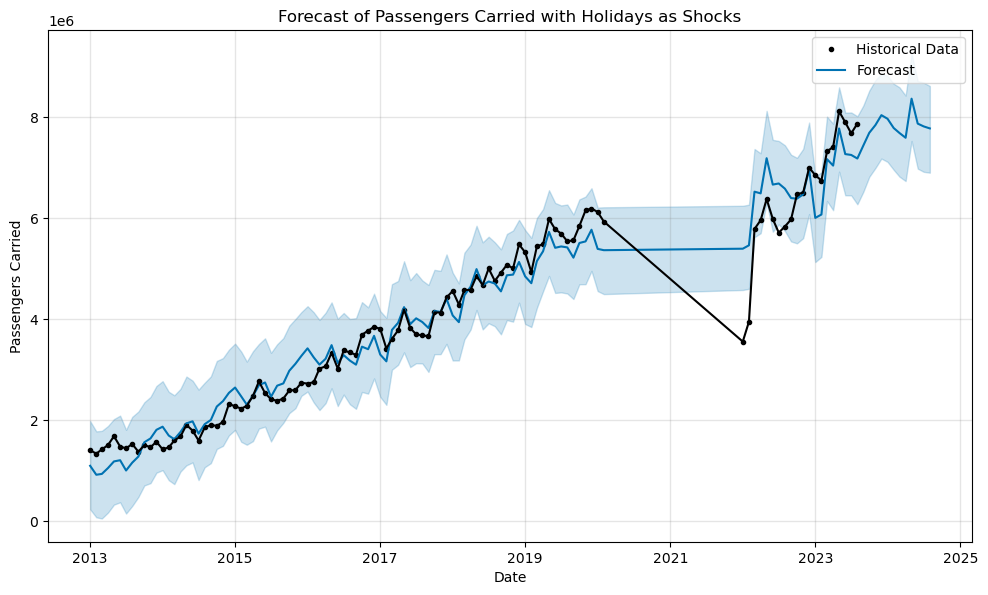

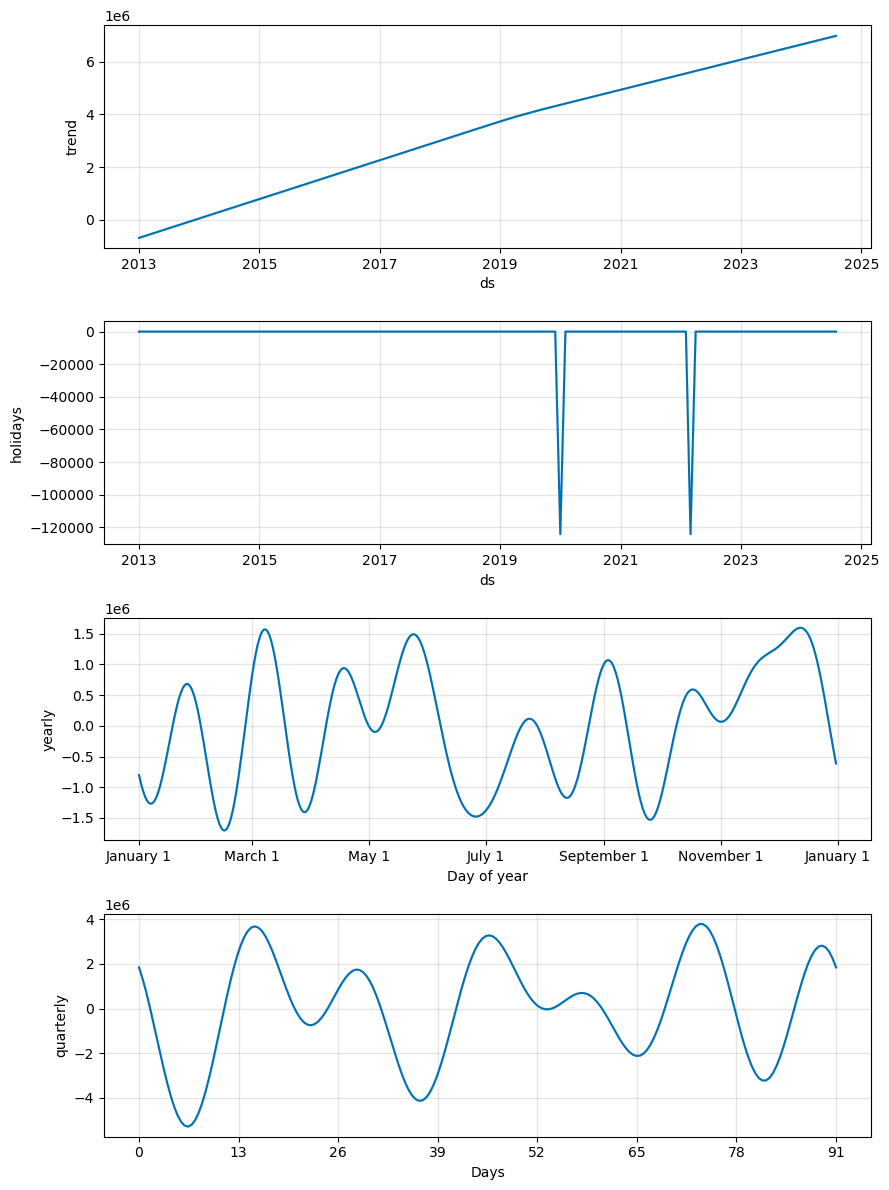

            ds          yhat    yhat_lower    yhat_upper
105 2023-08-01  7.177354e+06  6.272352e+06  8.012862e+06
106 2023-08-31  7.433464e+06  6.518538e+06  8.224872e+06
107 2023-09-30  7.686116e+06  6.815535e+06  8.519556e+06
108 2023-10-31  7.839186e+06  6.990310e+06  8.727692e+06
109 2023-11-30  8.034827e+06  7.176498e+06  8.852413e+06
110 2023-12-31  7.963410e+06  7.111178e+06  8.812539e+06
111 2024-01-31  7.780365e+06  6.954027e+06  8.656855e+06
112 2024-02-29  7.682503e+06  6.819220e+06  8.585415e+06
113 2024-03-31  7.587821e+06  6.731616e+06  8.421931e+06
114 2024-04-30  8.360926e+06  7.523827e+06  9.255914e+06
115 2024-05-31  7.867632e+06  6.976921e+06  8.709381e+06
116 2024-06-30  7.812496e+06  6.914528e+06  8.677551e+06
117 2024-07-31  7.772910e+06  6.897014e+06  8.612001e+06


In [41]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Prepare data for Prophet, excluding COVID-19 period
covid_start = '2020-03-01'
covid_end = '2021-12-31'
prophet_data = df[['PASSENGERS CARRIED']].rename(columns={'PASSENGERS CARRIED': 'y'}).reset_index().rename(columns={'Date': 'ds'})
# 
prophet_data = prophet_data[(prophet_data['ds'] < covid_start) | (prophet_data['ds'] > covid_end)]

# Define holidays representing shocks
holidays = pd.DataFrame({
    'holiday': 'Shock Event',
    'ds': pd.to_datetime(['2020-01-01', '2022-03-01']),  # Dates of significant events
    'lower_window': 0,  # Effects start on the day of the event
    'upper_window': 0,  # Effects last for only the day of the event
})

# Initialize Prophet with custom parameters
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='additive',
    interval_width=0.95, holidays=holidays
)

# Add the holidays to the model
# model.add_holidays(holidays)

# Add quarterly seasonality with moderate fourier_order
model.add_seasonality(name='quarterly', period=91.25, fourier_order=6)

# Fit the model
model.fit(prophet_data)

# Make a future dataframe and forecast
future_dates = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future_dates)

# Filter forecast for the last 12 months
last_12_months_forecast = forecast[forecast['ds'] >= forecast['ds'].max() - pd.DateOffset(months=12)]

# Plot the forecast with historical data
fig = model.plot(forecast)
plt.plot(prophet_data['ds'], prophet_data['y'], label="Historical Data", color='black')
plt.title("Forecast of Passengers Carried with Holidays as Shocks")
plt.xlabel("Date")
plt.ylabel("Passengers Carried")
plt.legend(["Historical Data", "Forecast"])
plt.show()

# Plot seasonal components
fig2 = model.plot_components(forecast)
plt.show()

# Show the last 12 months of forecast data
print(last_12_months_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])
